<a href="https://colab.research.google.com/github/Sanu3286/Traffic_Flow_Prediction/blob/main/HA_SVR_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. EXPLORATORY ANALYSIS

# Import required library

In [123]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy.linalg as la
import math
from sklearn.svm import SVR
from statsmodels.tsa.arima_model import ARIMA

# Uploading dataset from PC to Colab

In [124]:
from google.colab import files
uploaded = files.upload()
import io

#reading dataset from colab to python file

In [125]:
data=pd.read_csv(r'/content/traffic_speed.csv')
data

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,765604,767471,716339,773906,765273,716331,771667,716337,769953,769402,769403,769819,769405,716941,717578,716960,717804,767572,767573,773012,773013,764424,769388,716328,717819,769941,760987,718204,718045,769418,...,717582,717583,717580,716949,717587,772178,717585,716939,768469,764101,767554,773975,773974,717510,717513,717825,767495,767494,717821,717823,717458,717459,769926,764858,717450,717452,717453,759772,717456,771673,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
0,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125000,67.125000,59.625000,62.750000,55.500000,66.500000,64.250000,68.500000,60.375000,67.500000,37.750000,63.125000,59.750000,62.125000,67.250000,41.250000,54.625000,58.125000,65.125000,64.250000,61.250000,62.750000,66.875000,47.375000,57.000000,67.750000,65.125000,66.875000,64.000000,62.000000,64.375000,60.750000,60.750000,62.375000,...,68.250000,62.000000,64.500000,58.375000,64.500000,63.625000,63.750000,53.625000,69.875000,64.750000,62.375000,64.750000,52.125000,61.625000,63.000000,67.142857,67.625000,63.875000,63.125000,63.375000,64.125000,66.875000,69.875000,67.750000,62.000000,66.750000,57.625000,52.625000,69.000000,43.500000,45.625000,65.500000,64.500000,66.428571,66.875000,59.375000,69.000000,59.250000,69.000000,61.875000
1,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000000,65.000000,57.444444,63.333333,58.777778,58.444444,66.444444,65.444444,56.111111,65.444444,39.000000,63.777778,63.111111,66.111111,65.777778,56.777778,50.777778,56.222222,66.888889,54.444444,67.888889,61.555556,67.555556,46.777778,67.777778,67.888889,68.000000,67.444444,66.444444,67.222222,63.000000,64.333333,64.000000,61.888889,...,66.777778,66.555556,67.333333,55.333333,66.555556,66.555556,65.777778,59.888889,66.888889,67.444444,62.222222,62.222222,52.333333,47.666667,67.111111,64.500000,69.111111,63.888889,60.444444,65.777778,63.888889,69.333333,63.000000,67.666667,67.333333,66.666667,65.777778,51.666667,69.111111,39.888889,50.666667,69.875000,66.666667,58.555556,62.000000,61.111111,64.444444,55.888889,68.444444,62.875000
2,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500000,64.250000,63.875000,65.375000,61.375000,62.375000,64.750000,65.250000,61.875000,67.875000,35.250000,63.875000,35.625000,65.000000,69.125000,49.125000,55.625000,59.125000,67.875000,63.125000,63.000000,64.500000,59.000000,47.750000,61.571429,66.500000,68.500000,65.000000,66.250000,51.250000,63.875000,64.875000,65.625000,64.625000,...,64.000000,67.375000,65.250000,58.125000,64.625000,67.375000,66.750000,56.000000,68.750000,65.625000,61.000000,63.500000,56.125000,61.375000,64.125000,66.000000,68.625000,67.250000,64.000000,66.875000,65.000000,65.500000,54.875000,68.750000,67.375000,65.750000,56.250000,49.375000,67.250000,38.250000,44.125000,69.000000,56.500000,59.250000,68.125000,62.500000,65.625000,61.375000,69.857143,62.000000
3,61.777778,65.500000,62.555556,59.888889,66.777778,67.166667,63.222222,65.277778,63.583333,64.694444,62.138889,63.694444,64.055556,65.277778,60.472222,68.027778,39.500000,64.250000,37.527778,65.666667,67.750000,50.305556,53.416667,60.638889,68.250000,64.083333,64.666667,64.111111,61.111111,49.944444,60.714286,66.777778,67.777778,65.222222,65.833333,53.388889,65.916667,65.583333,63.750000,64.194444,...,66.000000,65.583333,66.833333,58.083333,62.750000,66.027778,64.277778,58.333333,68.833333,64.194444,62.333333,62.666667,51.972222,62.916667,64.305556,64.000000,68.527778,65.944444,63.777778,66.583333,62.888889,66.777778,54.694444,67.722222,66.805556,65.944444,58.388889,51.138889,68.166667,37.833333,43.416667,69.333333,60.444444,58.611111,67.416667,59.888889,65.305556,60.138889,69.571429,60.444444
4,59.555556,67.250000,65.111111,60.777778,67.055556,68.083333,61.944444,66.305556,63.291667,64.013889,62.902778,65.013889,63.361111,65.305556,59.069444,68.180556,43.750000,64.625000,39.430556,66.333333,66.375000

# Checking shape and data type of each column (node or feature)

In [130]:
print(data.shape)
print(data.dtypes)


(2016, 207)
773869    float64
767541    float64
767542    float64
717447    float64
717446    float64
           ...   
717592    float64
717595    float64
772168    float64
718141    float64
769373    float64
Length: 207, dtype: object


#checking how traffic speed is distributed what is min, max and other parameter.

In [131]:
data.describe()
# here we can see mean and median are nearly equal means there are less chance of more outliers


,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,765604,767471,716339,773906,765273,716331,771667,716337,769953,769402,769403,769819,769405,716941,717578,716960,717804,767572,767573,773012,773013,764424,769388,716328,717819,769941,760987,718204,718045,769418,...,717582,717583,717580,716949,717587,772178,717585,716939,768469,764101,767554,773975,773974,717510,717513,717825,767495,767494,717821,717823,717458,717459,769926,764858,717450,717452,717453,759772,717456,771673,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
count,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,...,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000
mean,62.763583,64.417668,63.979869,53.452817,49.454063,57.360487,58.732975,63.114587,60.637979,57.301726,61.269383,63.423923,41.846590,64.398948,55.699862,49.089496,31.815123,57.810642,56.440850,58.856556,65.132603,60.216706,48.557267,56.513327,64.516697,60.297215,53.306133,61.555459,65.333056,43.666447,59.080209,65.800319,64.517593,58.636592,62.466714,61.280950,65.581553,63.250784,48.338056,57.488335,...,66.054028,65.201047,65.430350,55.844292,66.237726,57.643417,65.491556,51.798110,61.298795,61.790180,62.048568,63.698491,55.358413,58.979917,62.232522,63.064966,67.626366,63.568813,62.314304,60.345021,45.195413,62.534089,62.327883,60.719998,49.169533,59.136428,45.238753,56.097432,63.479527,34.309121,42.184627,62.143217,58.091823,63.675389,64.702822,62.757956,66.698920,57.697911,64.243748,57.233853
std,10.728777,3.581343,10.848555,8.253062,15.079007,10.093574,11.033028,3.360304,8.567795,18.914828,3.683439,3.457313,23.057024,6.952644,15.067774,15.043599,7.468711,8.408188,5.542413,9.269522,6.803235,5.784059,7.185148,10.940784,4.978283,10.679739,12.833931,3.061266,10.821928,11.117565,7.343598,2.278255,6.561482,8.628173,10.871226,5.350082,7.195506,9.009931,20.217031,8.332656,...,4.653443,4.385876,3.668262,10.090348,2.744106,11.962026,3.259011,15.269522,12.020743,16.075225,3.121420,5.832121,4.157588,6.928596,6.065770,10.240869,1.695810,2.897672,9.844585,11.917152,22.330044,9.850233,5.095581,11.249606,16.159814,9.198104,16.908424,7.720489,10.752122,7.145998,9.457004,14.567386,12.648379,4.399367,7.903647,3.876873,3.742136,7.903004,8.177542,13.805025
min,2.500000,25.000000,13.000000,9.500000,9.625000,10.888889,15.500000,8.000000,4.250000,5.625000,23.875000,27.666667,4.000000,15.333333,3.111111,8.666667,8.000000,11.250000,30.375000,8.111111,18.875000,30.000000,17.333333,4.750000,30.111111,14.000000,5.500000,9.000000,7.125000,1.250000,3.125000,36.000000,25.777778,8.375000,6.333333,37.625000,2.666667,23.500000,5.285714,12.625000,...,13.875000,38.375000,42.000000,14.875000,47.111111,13.750000,2.000000,7.000000,15.250000,4.888889,27.250000,13.444444,12.555556,15.222222,14.375000,3.875000,56.500000,29.888889,5.250000,6.625000,4.888889,6.777778,34.222222,7.555556,7.875000,11.625000,9.125000,22.000000,7.888889,8.285714,1.000000,5.625000,8.333333,25.000000,10.000000,24.111111,24.125000,2.000000,9.000000,4.875000
25%,63.597222,63.656250,65.567460,51.625000,36.000000,54.222222,58.541667,61.875000,59.375000,60.111932,59.444444,62.250000,17.55

# checking null value

In [129]:
data.isnull()
#if there is false means no null value

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,765604,767471,716339,773906,765273,716331,771667,716337,769953,769402,769403,769819,769405,716941,717578,716960,717804,767572,767573,773012,773013,764424,769388,716328,717819,769941,760987,718204,718045,769418,...,717582,717583,717580,716949,717587,772178,717585,716939,768469,764101,767554,773975,773974,717510,717513,717825,767495,767494,717821,717823,717458,717459,769926,764858,717450,717452,717453,759772,717456,771673,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2012,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

# count all the null value in dataset for varification 

In [98]:
data.isna().sum().sum()
#counting null value is zeero

0

Text(0, 0.5, 'Traffic_Speed')

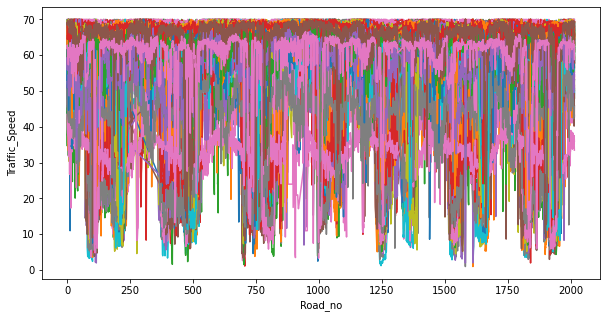

In [58]:
fig=plt.figure(figsize=(10,5))
plt.plot(data)
plt.xlabel('Road_no')
plt.ylabel('Traffic_Speed')
## In Figure we can see that most of the road network have traffic speed 40 to 70 few point are between 2 to 20

(array([[  0.,   0.,   0., ...,  17.,  53., 130.],
        [  0.,   0.,   0., ...,  17.,  54., 128.],
        [  0.,   0.,   0., ...,  16.,  64., 120.],
        ...,
        [  0.,   0.,   0., ...,  24.,  51., 125.],
        [  0.,   0.,   0., ...,  16.,  52., 131.],
        [  0.,   0.,   0., ...,  13.,  59., 127.]]),
 array([ 1. ,  7.9, 14.8, 21.7, 28.6, 35.5, 42.4, 49.3, 56.2, 63.1, 70. ]),
 <a list of 2016 Lists of Patches objects>)

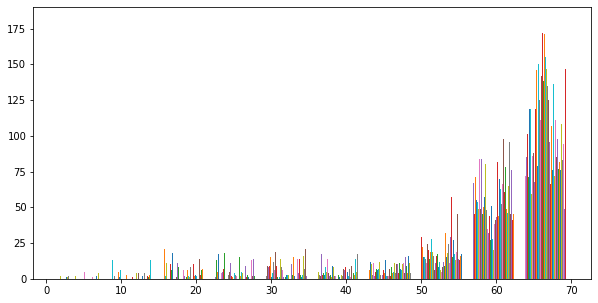

In [57]:
fig=plt.figure(figsize=(10,5))
plt.hist(data)

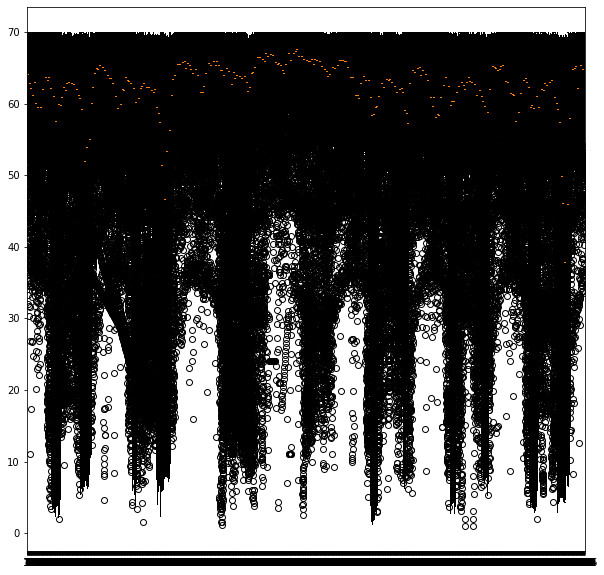

In [59]:
fig=plt.figure(figsize=(10,10))
plt.boxplot(data)
plt.show()

#  Data Preprocessing

In [13]:
def preprocess_data(data, time_len, rate, seq_len, pre_len):
    data1 = np.mat(data)
    train_size = int(time_len * rate)
    train_data = data1[0:train_size]
    test_data = data1[train_size:time_len]
    
    trainX, trainY, testX, testY = [], [], [], []
    for i in range(len(train_data) - seq_len - pre_len):
        a = train_data[i: i + seq_len + pre_len]
        trainX.append(a[0 : seq_len])
        trainY.append(a[seq_len : seq_len + pre_len])
    for i in range(len(test_data) - seq_len -pre_len):
        b = test_data[i: i + seq_len + pre_len]
        testX.append(b[0 : seq_len])
        testY.append(b[seq_len : seq_len + pre_len])
    return trainX, trainY, testX, testY

# Model Evaluation Parameter

In [14]:
###### evaluation ######
def evaluation(a,b):
  rmse = math.sqrt(mean_squared_error(a,b))
  mae = mean_absolute_error(a, b)
  F_norm = la.norm(a-b)/la.norm(a)
  r2 = 1-((a-b)**2).sum()/((a-a.mean())**2).sum()
  var = 1-(np.var(a - b))/np.var(a)
  return rmse, mae, 1-F_norm, r2, var

In [16]:
time_len = data.shape[0]
num_nodes = data.shape[1]
train_rate = 0.8
seq_len = 12
pre_len = 3
trainX,trainY,testX,testY = preprocess_data(data, time_len, train_rate, seq_len, pre_len)
method1='HA'
method2='SVR'
method3='ARIMA'

# 2. MODEL TRAINING

**IMPLEMENTATION OF HISTORICAL AVG MODEL**

In [22]:
if method1 == 'HA':
    result = []
    for i in range(len(testX)):
        a = testX[i]
        a1 = np.mean(a, axis=0) 
        result.append(a1)
    result1 = np.array(result)
    result1 = np.reshape(result1, [-1,num_nodes])
    testY1 = np.array(testY)
    testY1 = np.reshape(testY1, [-1,num_nodes])
    testY1 =testY1[:389]
    
 
    rmse1, mae1, acc1,r1,var1 = evaluation(testY1, result1)  
    print('--------------------HA MODEL-------------------')
    print('HA_rmse:%r'%rmse1)
    print('HA_mae:%r'%mae1)
    print('HA_acc:%r'%acc1)
    print('HA_r2:%r'%r1)

 

--------------------HA MODEL-------------------
HA_rmse:16.174892015255377
HA_mae:9.65228457616031
HA_acc:0.7322557890521755
HA_r2:-0.9587359047149528


# IMPLEMENTATION OF SUPPORT VECTOR REGRESSION MODEL

In [21]:
if method2 == 'SVR':  
    total_rmse, total_mae, total_acc, result = [], [],[],[]
    for i in range(num_nodes):
        data1 = np.mat(data)
        a = data1[:,i]
        a_X, a_Y, t_X, t_Y = preprocess_data(a, time_len, train_rate, seq_len, pre_len)
        a_X = np.array(a_X)
        a_X = np.reshape(a_X,[-1, seq_len])
        a_Y = np.array(a_Y)
        a_Y = np.reshape(a_Y,[-1, pre_len])
        a_Y = np.mean(a_Y, axis=1)
        t_X = np.array(t_X)
        t_X = np.reshape(t_X,[-1, seq_len])
        t_Y = np.array(t_Y)
        t_Y = np.reshape(t_Y,[-1, pre_len])    
       
        svr_model=SVR(kernel='rbf')
        svr_model.fit(a_X, a_Y)
        pre = svr_model.predict(t_X)
        pre = np.array(np.transpose(np.mat(pre)))
        pre = pre.repeat(pre_len ,axis=1)
        result.append(pre)
    result1 = np.array(result)
    result1 = np.reshape(result1, [num_nodes,-1])
    result1 = np.transpose(result1)
    testY1 = np.array(testY)
    testY1 = np.reshape(testY1, [-1,num_nodes])
    total = np.mat(total_acc)
    total[total<0] = 0
    rmse2, mae2, acc2,r2,var2 = evaluation(testY1, result1)
    print('SVR_rmse:%r'%rmse2)
    print('SVR_mae:%r'%mae2)
    print('SVR_acc:%r'%acc2)
    print('SVR_r2:%r'%r2)
    print('SVR_var:%r'%var2)    


SVR_rmse:6.699298112971336
SVR_mae:3.53522141722281
SVR_acc:0.8859519292255663
SVR_r2:0.7667102368409632
SVR_var:0.7735693215515071


#IMPLEMENTATION OF ARIMA MODEL

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


arima_rmse:10.073228775806024
arima_mae:7.677592052702164
arima_acc:0.8273057958571809
arima_r2:-0.020345519731693712
arima_var:0.0015762975114082406


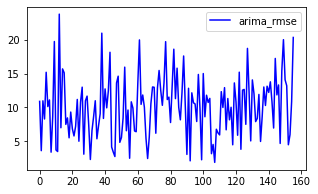

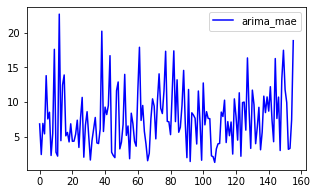

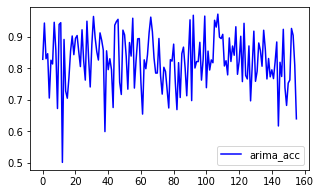

In [ ]:
if method3 == 'ARIMA':
    rng = pd.date_range('1/3/2012', periods=5664, freq='15min')
    a1 = pd.DatetimeIndex(rng)[:2016]
    data.index = a1
    num = data.shape[1]   
    rmse,mae,acc,r2,var,pred,ori = [],[],[],[],[],[],[]
    for i in range(156):
        ts = data.iloc[:,i]
        ts_log=np.log(ts)    
        ts_log=np.array(ts_log,dtype=np.float)
        where_are_inf = np.isinf(ts_log)
        ts_log[where_are_inf] = 0
        ts_log = pd.Series(ts_log)
        ts_log.index = a1
        model = ARIMA(ts_log,order=[1,0,0])
        properModel = model.fit()
        predict_ts = properModel.predict(4, dynamic=True)
        log_recover = np.exp(predict_ts)
        ts = ts[log_recover.index]
        er_rmse,er_mae,er_acc,r2_score,var_score = evaluation(ts,log_recover)
        rmse.append(er_rmse)
        mae.append(er_mae)
        acc.append(er_acc)
        r2.append(r2_score)
        var.append(var_score)
    acc1 = np.mat(acc)
    acc1[acc1 < 0] = 0
    print('arima_rmse:%r'%(np.mean(rmse)))
    print('arima_mae:%r'%(np.mean(mae)))
    print('arima_acc:%r'%(np.mean(acc)))
    print('arima_r2:%r'%(np.mean(r2)))
    print('arima_var:%r'%(np.mean(var)))
## rmse###
fig1 = plt.figure(figsize=(5,3))
plt.plot(rmse, 'b-', label="arima_rmse")
plt.legend(loc='best',fontsize=10)
plt.show()
 ### mae###
fig1 = plt.figure(figsize=(5,3))
plt.plot(mae, 'b-', label="arima_mae")
plt.legend(loc='best',fontsize=10)
plt.show()
###ACC###
fig1 = plt.figure(figsize=(5,3))
plt.plot(acc, 'b-', label="arima_acc")
plt.legend(loc='best',fontsize=10)
plt.show()